In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from copy import deepcopy
import warnings


warnings.simplefilter("ignore")

In [187]:
seed = 21

In [188]:
X, y = make_classification(n_features=2, n_classes=2, n_redundant=0, random_state=seed, shuffle=True)
df = pd.DataFrame(np.concatenate([X, y.reshape(-1, 1)], axis=1), columns=['f1', 'f2', 'target'])
df.head(3)

,f1,f2,target
0,0.062020,-1.566943,0.0
1,-1.902629,-0.056498,1.0
2,-1.779908,-0.190826,0.0


In [189]:
#def kmeans(d):
  # Выбираем случайные точки

def euclidean_dist(center, X):
  # корень суммы квадратов разности Centeri Xi
  return np.sum((X - center)**2)**0.5

def sigm(X):
  return 1 / (1 + np.exp(-1 * X))

def plot_centers(df, centers, new_centers=None):
  fig, ax = plt.subplots()

  g = sns.scatterplot(
    data=df,
    x='f1',
    y='f2',
    hue='target',

    ax=ax
  )
  ax.scatter(centers[:, 0], centers[:, 1], color='red')
  if new_centers is not None:
    ax.scatter(new_centers[:, 0], new_centers[:, 1], color='yellow')

  g.set_title('Dataset overview')
  plt.show()

def pick_random_centers(df, k=2):
  if 'target' in df.columns:
    data = df.copy(True).iloc[:, :-1]
  else:
    data = df
  
  idx = np.random.randint(0, len(data))

  centers = []
  s_center = data.iloc[idx, :]
  data.drop(idx, inplace=True)

  for i in range(k - 1):
    # считаем расстояние от каждой точки до верхнего центра для обозначения вероятностей
    new_dist = []
    for X_point in data.values:
      X_point_dist = euclidean_dist(s_center, X_point)
      new_dist.append(X_point_dist)


    # посчитаем вероятность выбора нового центра полагаясь на расстояние от базового центра
    data['dist'] = new_dist
    s = data.dist.sum()
    data['dist'] = data.dist / s

    # выбираем центр
    new_idx = np.random.choice(data.index, p=data.dist)
    if 'dist' in s_center:
      s_center.drop('dist', inplace=True)
    centers.append(s_center.values)

    s_center = data.iloc[new_idx, :]
    data.drop(new_idx, inplace=True)

  if 'dist' in s_center:
    s_center.drop('dist', inplace=True)
  centers.append(s_center.values)

  return np.array(centers)

class KMeans:
    def __init__(self, k=2, epsilon = 0.05):
        self.k = k
        self.e = epsilon
    
    def fit(self, df, rounds=50):
        # Для целей отладки сохраню изначальные центры
        self.base_centers = pick_random_centers(df.copy(True), self.k)
        centers = deepcopy(self.base_centers)
        
        for i_round in range(rounds):
            # Шаг 1. Определяем принадлежность
            centers_info = {i:[] for i in range(len(centers))}
            dist_info = np.zeros(len(centers))
        
            for curr_p in df.values:
                # Посчитаем расстояние до всех центров
                for i, center_p in enumerate(centers):
                    dist_info[i] = euclidean_dist(center_p, curr_p)
            
            
                shortest_dist_index = np.argmin(dist_info)
                centers_info[shortest_dist_index].append(curr_p)
        
            # Шаг 2. Теперь считаем координаты новых центров
            for i in range(len(centers)):
                curr_points = np.array(centers_info[i])
                new_center = curr_points.mean(axis=0)
                centers[i] = new_center
        
        self.trained_centers = centers
    
    def clusterize(self, df):
        df = df.copy()
        dist_info = np.zeros(len(self.trained_centers))
        
        results = []
        for curr_p in df.values:
            for i, center_p in enumerate(self.trained_centers):
                dist_info[i] = euclidean_dist(center_p, curr_p)
            results.append(np.argmin(dist_info))
            
        return results


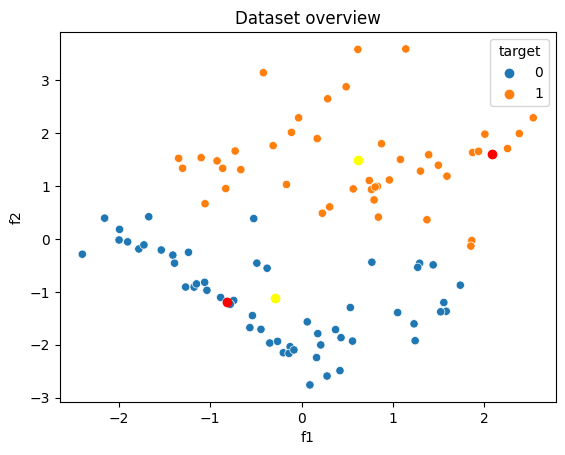

In [193]:
data = df[['f1', 'f2']]

cls = KMeans(k=2)
clusterized = cls.fit(data)

plot_df = df.copy()
plot_df['target'] = cls.clusterize(data)
plot_centers(plot_df, cls.base_centers, cls.trained_centers)

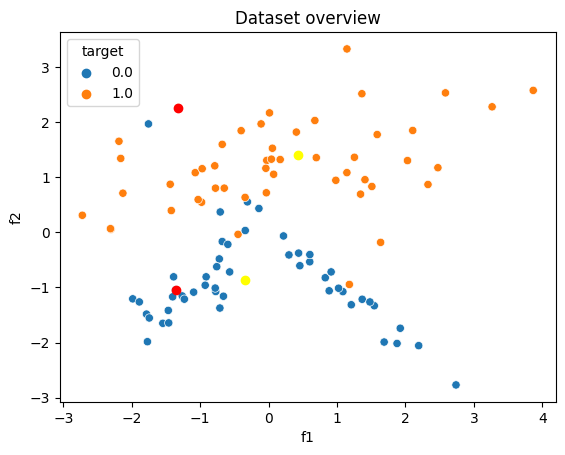

In [186]:
plot_centers(df, cls.base_centers, cls.trained_centers)